Testing out the puma topic model. Better description pending...

In [2]:
import numpy as np
from collections import namedtuple
ProteinComplex = namedtuple("ProteinComplex", ["Name", "Counts"])
%matplotlib inline

ok, after failing for a while with python's relative imports system and how that interacts with ipython's namespace, I'm giving up at importing the existing *puma.py* module, and I simply recreate it below. This is super sub-optimal and I would love to figure this one out...
This is gonna get real sloppy if there's any changes to the code below relative to the code in the module, *really* need to avoid that...

In [3]:

import numpy.random as r
from collections import Counter
from itertools import groupby
from functools import reduce  

class model():
    def __init__(self):
        pass  
    
    def simData(self,D):
        '''
        Simulate some fake data for sanity checks. Data drawn from 3 topics, D documents, with vocabulary of size 4.
        Superbly inflexible method for synthetic data generation, but all we need for now.
        '''
        thetas = [ [.9,.1,0,0],[.25, .25, .25, .25],[0,.1,.1,.8]]
        docs = []
        for i in range(D):
            pr = thetas[r.choice([0,1,2])]
            c = Counter(r.choice(range(len(pr)), size= r.poisson(15),p = pr  ))
            docs.append( [c.get(s,0) for s in [0,1,2,3] ] )
        return docs
            
        
    def probability_doc_given_topics(self,doc,topic_probs):
        '''
        Given the parameters of a single topic, return likelihood of the doc given the parameters. 
        Input
            doc: List[Int]
            topics_probs: List[Double]
        '''
       
        return reduce(lambda a,b:a*b, [b**a for (a,b) in zip(doc,topic_probs)])
    
    def topicSample(self, doc, params):
        '''
        Resample the topic label of the doc.
        Inputs
            doc: List[Int]
            params: List[(Int, List[Float])]
        '''
        probabilities = []
        for T in params:
            
            probabilities.append( self.probability_doc_given_topics(doc[1],T[1]) )
        probabilities = [p/float(sum(probabilities)) for p in probabilities]
        draw = r.choice(range(len(params)),1,p=probabilities)
        return (draw[0], doc[1])
    
    def parameterSample(self, allData):
        '''
        Given the document labels, resample the parameters for each topic.
        '''
        
        allData.sort(key = lambda a: a[0])
        grouped = [(k, [thing[1] for thing in g]) for k,g in groupby(allData, lambda s: s[0])]
        group_counts = [(group[0], reduce(lambda a,b: [a[i] + b[i] for i in range(len(a))]   ,group[1]) ) for group in grouped]
        group_probs = [(k, r.dirichlet(c).tolist()) for k,c in group_counts]
        return group_probs
        
        
    def run(self,corpus,num_topics, iterations):
        '''
        Run Gibbs sampler for puma model.
        Inputs
            corpus: List[List[Int]]
            num_topics: Int
            iterations: Int
        '''
        
        
        #  transform corpus by adding randomized topic labes, resulting in list of (label, [counts])
        # ex [ (1, [0,1,0,8]),  (0, [2,5,0,0]), (1, [3,4,9,1])  ]
        labeledCorpus = map( lambda c: (r.choice(range(num_topics)) ,c) ,corpus)
        
        for i in range(iterations):
        
            # sample the parameters given the labels
            topicParameters = self.parameterSample(labeledCorpus)
            
            # sample the labels given the parameters
            labeledCorpus = map(lambda doc: self.topicSample(doc,topicParameters) ,labeledCorpus)
            
        return topicParameters

Here's a function for data ingest

In [4]:
def dataIngest(filename):
    '''
    Read in the data, parse it.
    Return a list of those ProteinComplex objects, and also the column header names for later use.
    '''
    with open(filename, "r") as inFile:
        txt = inFile.read()
    lines = txt.split("\n") 
    columnNames = lines[0].split("\t")[1:]
    dataset =  [ProteinComplex(line.split("\t")[0],[float(i) for i in line.split("\t")[1:]]) for line in lines[1:-1] ] # some rough python...
    return dataset, columnNames

Now we read in the data file. BJL: Changed int() to float() in dataset assignment line so we can read in dist file.

In [5]:
dataset, columnNames = dataIngest("../fixtures/corum_phylome_dist.txt")
vocab_dictionary = dict(zip(range(len(columnNames)), columnNames ))

Run the puma model on the data (100 iterations takes a little while)

In [18]:
corpus = map(lambda l: l[1],dataset)
p = model()
result = p.run(corpus,num_topics=4, iterations= 100)

In [19]:
print result

[(0, [0.13355311116944188, 0.04353816101997009, 0.06926669129708894, 0.34203153611672715, 0.08377937316033468, 0.009752988859999222, 0.1505915982179797, 0.10043930447880134, 0.06704723567965708]), (1, [0.1117729271691021, 0.030213919405225605, 0.08931662133339084, 0.3721630143899058, 0.06936441614933003, 0.025077478972662718, 0.10008165657677232, 0.12861362344024058, 0.07339634256336997]), (2, [0.08451158231863999, 0.017496631679122392, 0.07169502518182641, 0.3454551830218525, 0.0856546474740026, 0.013153712779394679, 0.19797066085536458, 0.1049660025079117, 0.07909655418188516]), (3, [0.10898911171406174, 0.019401774293741854, 0.09530830517624053, 0.34529262407612243, 0.07632609228009175, 0.016597683900251653, 0.15889046588819508, 0.12956422095362474, 0.04962972171767017])]


So those are the topics, none too pretty, let's do some visualization. 

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10 #this changes the size of figures in this notebook

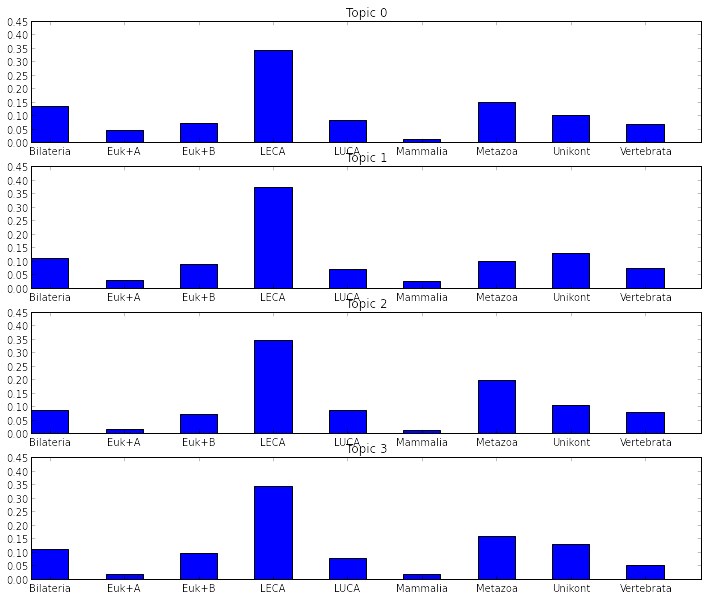

In [21]:
plt.figure(2)
bar_width = 0.5

for i in result:
    topicIndex,topicParams = i[0],i[1]
    index = np.arange(len(topicParams))
    loc = int("41" + str(topicIndex + 1))
    plt.subplot(loc)
    plt.bar(index,result[topicIndex][1], bar_width)
    plt.xticks(index + bar_width/2, vocab_dictionary.values())
    plt.yticks(np.arange(0,.5,.05))
    topicName = "Topic " + str(topicIndex)
    plt.title(topicName)

plt.show()

BJL: How's that?

**Methods**

When I get a chance, I'll write out the full details of this Bayesian latent variable model and what this Gibbs sampler is doing.